In [74]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *

In [75]:
def add_truth(df, source='icosari', disease='sari'):
    df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/latest_data-{source}-{disease}.csv')
    df_truth = df_truth.rename(columns={'value': 'truth'})

    df = df.merge(df_truth, how='left', 
                   left_on=['location', 'age_group', 'target_end_date'], 
                   right_on=['location', 'age_group', 'date'])
    return df

In [76]:
def load_predictions(source='icosari', disease='sari', period='test', include_median=True, include_truth=True):
    files = glob.glob(f'../data/pre-covid/*.csv') 
    
    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file.split('/')[-1].split('-')[0]
        df_temp['test_year'] = file[-8:-4]
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    if include_median:
        df = add_median(df)
    if include_truth:
        df = add_truth(df, source, disease)

    return df

In [77]:
df = load_predictions('icosari', 'sari')

In [78]:
df.model.unique()

array(['tsmixer_median_ensemble', 'lightgbm0', 'arima_scaled',
       'tsmixer2_median_ensemble', 'lightgbm_ensemble', 'tsmixer_old',
       'lightgbm_median_ensemble', 'tsmixer_ensemble', 'lightgbm',
       'tsmixer2_ensemble', 'tsmixer', 'tsmixer0', 'arima'], dtype=object)

In [79]:
df = df[~df.model.str.contains('old')]

#### National level

In [80]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,tsmixer,172.606496,182.642602,225.182398,580.431496,0.357143,0.892857
1,lightgbm,188.536407,310.274078,115.395800,614.206285,0.377551,0.724490
2,lightgbm0,185.994254,314.388210,115.506254,615.888718,0.357143,0.709184
3,lightgbm_median_ensemble,190.550378,251.077340,175.051183,616.678901,0.346939,0.719388
4,lightgbm_ensemble,193.431796,249.947691,174.363443,617.742929,0.362245,0.714286
5,tsmixer2_median_ensemble,273.431860,228.137908,157.692857,659.262625,0.581633,0.933673
6,tsmixer2_ensemble,272.500310,303.127520,157.306735,732.934566,0.494898,0.897959
7,tsmixer_median_ensemble,277.757332,388.131735,70.037245,735.926311,0.515306,0.938776
8,tsmixer_ensemble,280.012839,398.757867,64.680408,743.451115,0.556122,0.948980
9,arima_scaled,316.003487,325.024170,230.089199,871.116856,0.515306,0.923469


#### Age groups

In [81]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,tsmixer2_median_ensemble,57.376627,83.527483,42.719396,183.623506,0.430272,0.869048
1,tsmixer2_ensemble,57.628769,90.358896,36.688597,184.676262,0.447279,0.868197
2,tsmixer_ensemble,58.324851,103.506124,26.476886,188.307861,0.477891,0.863095
3,lightgbm_ensemble,41.782733,94.685509,52.287058,188.755300,0.271259,0.696429
4,lightgbm_median_ensemble,41.367724,95.010199,52.500176,188.878099,0.265306,0.697279
5,tsmixer,41.885328,77.170459,70.913367,189.969154,0.344388,0.813776
6,tsmixer_median_ensemble,58.181151,106.940230,28.556701,193.678081,0.473639,0.857993
7,lightgbm0,40.102584,105.421910,48.453604,193.978099,0.234694,0.699830
8,lightgbm,40.010648,105.510822,48.505088,194.026558,0.237245,0.700680
9,arima_scaled,72.173929,70.835340,59.693798,202.703068,0.474490,0.877551


# Plots

In [39]:
from plotnine import ggplot, aes, geom_bar, geom_label, scale_alpha_manual, labs, coord_flip, theme_bw, theme, geom_line, scale_alpha_discrete, guide_legend

In [40]:
df_national = evaluate_models(df, 'national')

In [41]:
df_age = evaluate_models(df, 'age')

In [42]:
scores_national = pd.melt(df_national, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

In [43]:
scores_age = pd.melt(df_age, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


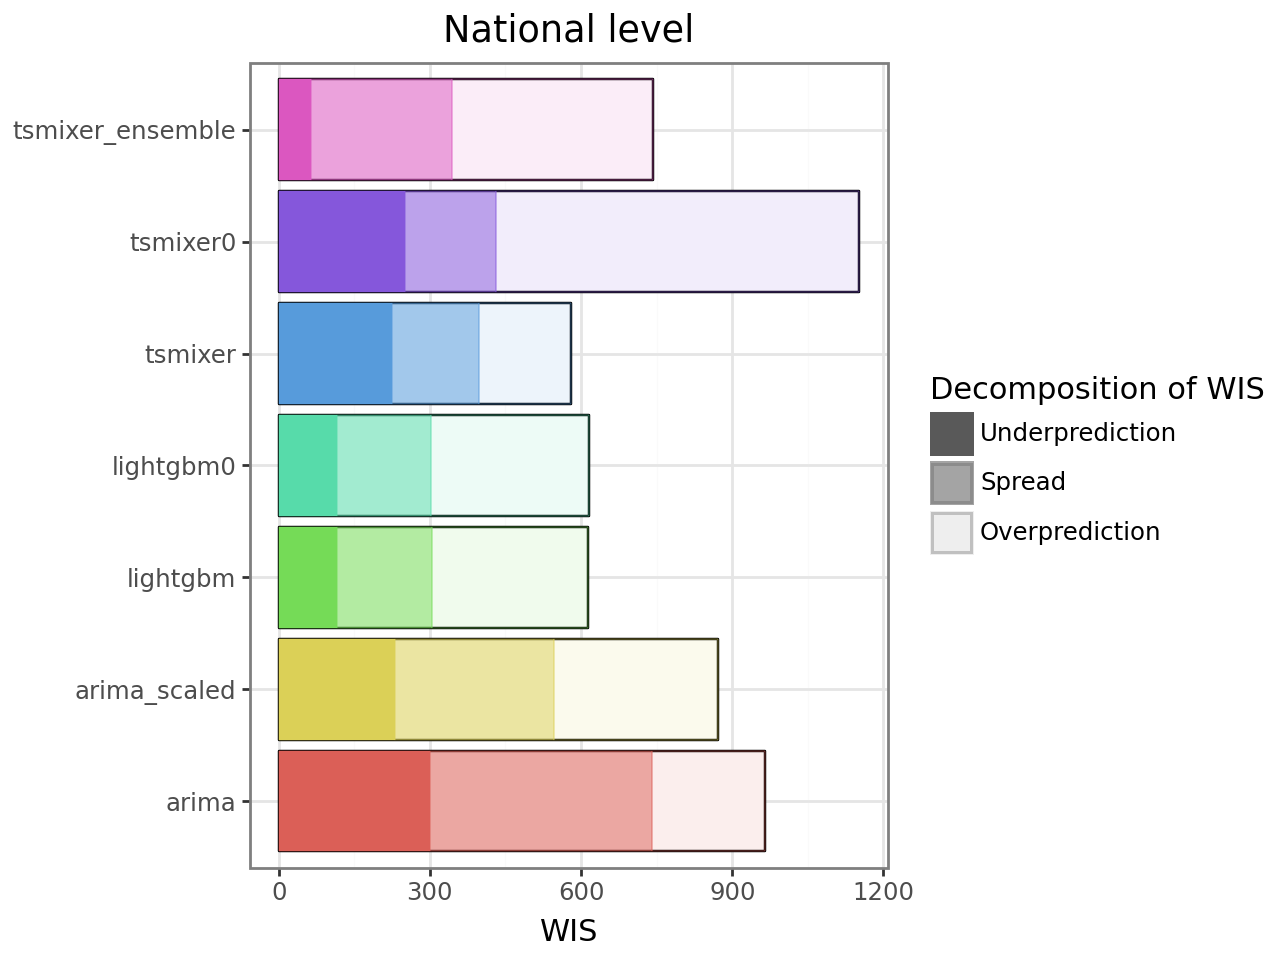

In [44]:
(ggplot()
    + geom_bar(df_national, aes(x='model', y='wis'), fill='white', color='black', stat='identity')
    + geom_bar(scores_national, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.1, stat='identity', 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS", title="National level")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='right')
   )

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


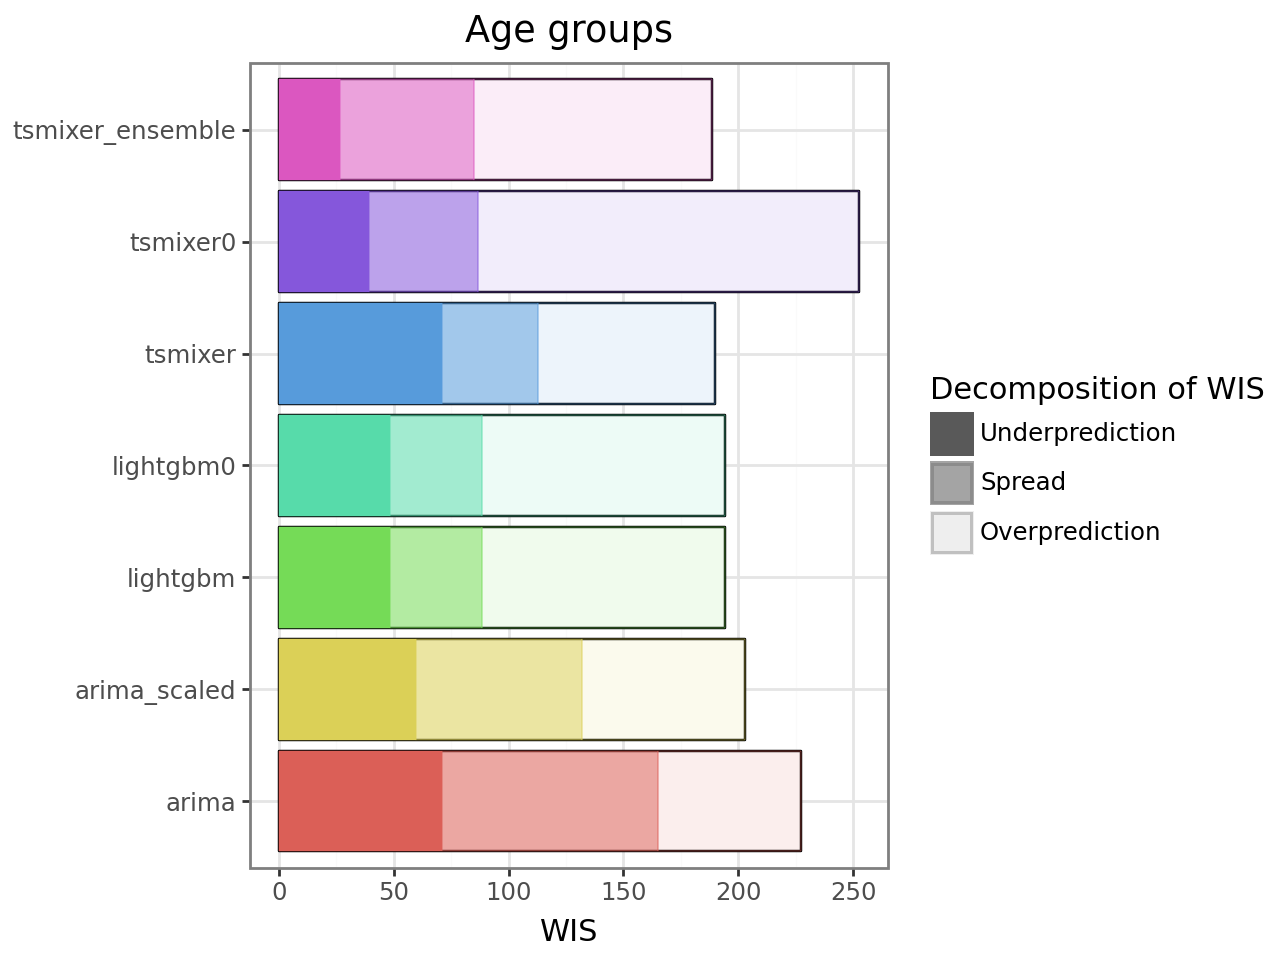

In [45]:
(ggplot()
    + geom_bar(df_age, aes(x='model', y='wis'), fill='white', color='black', stat='identity')
    + geom_bar(scores_age, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.1, stat='identity', 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS", title="Age groups")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='right')
   )